In [2]:
from app.interface import QuantumImaging
import h5py
import numpy as np
import matplotlib.pyplot as plt

In [3]:
qi = QuantumImaging(save_dir='./data/test.h5')

In [4]:
qi.run_initialisation()

No camera settings provided. Using defaults.


AttributeError: 'NV40' object has no attribute 'serial_conn'

In [39]:
qi.run_parameters([0,0,0,15.46], args=True)

0.6798323068571155

In [34]:
# qi.shutdown()
# import tables
# tables.file._open_files.close_all()
df =  h5py.File('./data/sampling.h5', 'r')

In [35]:
print(df.keys())
df.close()

<KeysViewHDF5 ['run_0', 'run_1', 'run_10', 'run_11', 'run_12', 'run_13', 'run_14', 'run_15', 'run_16', 'run_17', 'run_18', 'run_19', 'run_2', 'run_20', 'run_21', 'run_22', 'run_23', 'run_24', 'run_25', 'run_26', 'run_27', 'run_28', 'run_29', 'run_3', 'run_30', 'run_31', 'run_32', 'run_33', 'run_34', 'run_35', 'run_36', 'run_37', 'run_38', 'run_39', 'run_4', 'run_40', 'run_41', 'run_42', 'run_43', 'run_44', 'run_45', 'run_46', 'run_47', 'run_48', 'run_49', 'run_5', 'run_50', 'run_51', 'run_52', 'run_6', 'run_7', 'run_8', 'run_9']>


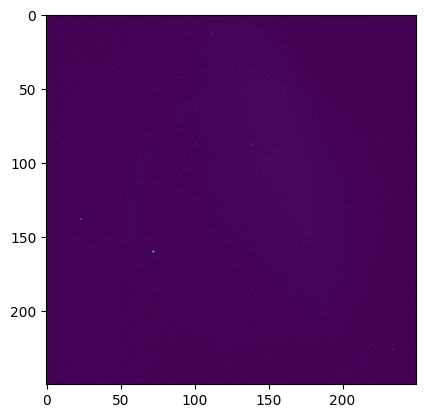

In [22]:
di = np.array(df['run_0']['dark_img'])
plt.imshow(di)
plt.show()

In [7]:
qi.shutdown()

In [10]:
qi.actuator_list['sig_arm_piezo'].set_parameters(100)

Exception in thread Thread-11 (_actions):
Traceback (most recent call last):
  File "/usr/lib/python3.12/threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "/home/computer/quantum-sensing-auto-alignment/venv/lib/python3.12/site-packages/ipykernel/ipkernel.py", line 766, in run_closure
    _threading_Thread_run(self)
  File "/usr/lib/python3.12/threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "/home/computer/quantum-sensing-auto-alignment/app/drivers.py", line 353, in _actions
    while not (int(position) - self._tol <= self._actuator.get_position(channel=axis) <= int(position) + self._tol) and not observed_twice:
                                            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/computer/quantum-sensing-auto-alignment/venv/lib/python3.12/site-packages/pylablib/core/utils/general.py", line 1120, in wrapped
    res=func(**all_args)
        ^^^^^^^^^^^^^^^^
  File "/home/computer/quantum-sensing-auto-al

KeyboardInterrupt: 

In [11]:
qi.shutdown()

In [1]:
from app.drivers import KIM101

In [2]:
sig_arm_piezo =  KIM101('/dev/ttyUSB3', 'sig_arm_piezo')
sig_arm_piezo.initialise(config_dict={})

In [8]:
sig_arm_piezo.set_parameters(0, axis=1)

In [10]:
sig_arm_piezo.shutdown()

In [9]:
sig_arm_piezo.get_position()

[0, 0]

In [5]:
from app.driver_libs.jena import NV40

In [6]:
nv =  NV40('/dev/ttyUSB7')

AttributeError: 'NV40' object has no attribute 'serial_conn'

In [46]:
nv.set_position(0)

In [47]:
nv.set_remote_control(False)

In [48]:
nv.__exit__(1,1,1)